In [1]:
import polars as pl 
import polars_ds as pds
import polars.selectors as cs
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
# To get the english dictionary
import nltk
from nltk.corpus import words,stopwords
import os 
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Downloading spaCy NLP model...")
    print("This may take a few minutes and it's one time process...")
    os.system(
        "pip install https://huggingface.co/spacy/en_core_web_sm/resolve/main/en_core_web_sm-any-py3-none-any.whl")
    nlp = spacy.load("en_core_web_sm")

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Yafee
[nltk_data]     Ishraq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read the data 

In [4]:
data = pl.read_csv('train.csv')

In [5]:
data.head()

id,keyword,location,text,target
i64,str,str,str,i64
1,null,null,"""Our Deeds are the Reason of th…",1
4,null,null,"""Forest fire near La Ronge Sask…",1
5,null,null,"""All residents asked to 'shelte…",1
6,null,null,"""13,000 people receive #wildfir…",1
7,null,null,"""Just got sent this photo from …",1


# Null values 

There are very few null values in keyword column. Location contains 2533 null values. Later I will be looking at a word cloud to see if there are any patterns in the text columns.

In [6]:
data.null_count()

id,keyword,location,text,target
u32,u32,u32,u32,u32
0,61,2533,0,0


# Text cleaning

## Simple cleaning operations

In [7]:
# Remove leading and trailing characters
data = data.with_columns(pl.col(pl.String).str.strip_chars())

# To lowercase
data = data.with_columns(pl.col(pl.String).str.to_lowercase())

# Remove stopwords. Stopwords from the nltk library
stop_words = stopwords.words('english')

# Making expressions for all string columns. The pl.all() method is not returning the expected outp
stop_word_expression = [pl.col(c).str.split(" ").list.set_difference(stop_words).list.join(" ").name.keep() for c in data.select(pl.col(pl.String)).columns]

# Apply expressions
data = data.with_columns(*stop_word_expression)


## Defining regex

In [8]:
import re

# Regex for removing http url 
regex_http_url = r'http[s]?://\S+'

# Regex for punctuations
regex_pattern_punctuations = '[' + re.escape(string.punctuation) + ']'

# Regex for special characters
regex_pattern_special_characters = r'^[^A-Za-z0-9]*$'

# Regex for numbers
regex_pattern_numbers = r'\d'

# Remove ascii
regex_pattern_ascii = r'[^\p{Ascii}]'

# Regex for 2 or more whitespace
regex_whitespace = r'\s{2,}'


## Run text cleaning

In [9]:

data = data.with_columns(pl.col('location')
                  .str.replace_all(regex_http_url," ")
                  .str.replace_all(regex_pattern_punctuations," ")
                  .str.replace_all(regex_pattern_special_characters," ")
                  .str.replace_all(regex_pattern_numbers," ")
                  .str.replace_all(regex_pattern_ascii," ")
                  .str.replace_all(regex_whitespace," ")
                  .str.strip_chars()
                  .alias('cleaned_location'),

                  pl.col('text')
                  .str.replace_all(regex_http_url," ") 
                  .str.replace_all(regex_pattern_punctuations," ")
                  .str.replace_all(regex_pattern_special_characters," ")
                  .str.replace_all(regex_pattern_numbers," ")
                  .str.replace_all(regex_pattern_ascii," ")
                  .str.replace_all(regex_whitespace," ")
                  .str.strip_chars()
                  .alias('cleaned_text'),

                  pl.col('keyword')
                  .str.replace_all(regex_http_url," ")
                  .str.replace_all(regex_pattern_punctuations," ")
                  .str.replace_all(regex_pattern_special_characters," ")
                  .str.replace_all(regex_pattern_numbers," ")
                  .str.replace_all(regex_pattern_ascii," ")
                  .str.replace_all(regex_whitespace," ")
                  .str.strip_chars()
                  .alias('cleaned_keyword')
)

## Lemmatizaion

In [10]:
# Using lemmatization framework from the downloaded model.
data = (data
.with_columns(pl.col('cleaned_text').map_elements(lambda x:[token.lemma_ for token in nlp(x)]))
.with_columns(pl.col('cleaned_text').list.join(" "))
)

## Descriptive statistics

<Axes: xlabel='target', ylabel='Average number of words per tweet'>

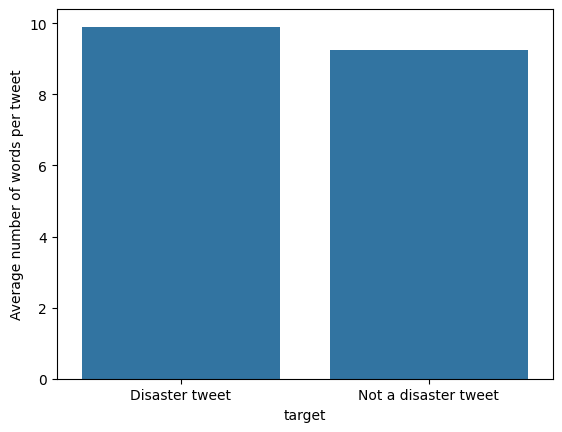

In [11]:
# Find the average number of words for each text
n_words = (data
.select('target',pl.col('cleaned_text').str.split(" "))
.with_columns(pl.col('cleaned_text').list.len().suffix('_word_length'))
.group_by(pl.col('target').replace(1,'Disaster tweet').replace(0,"Not a disaster tweet"))
.agg(pl.col('cleaned_text_word_length').mean().alias('Average number of words per tweet'))
)

sns.barplot(data = n_words.to_pandas(),x = 'target',y = 'Average number of words per tweet')

There are 221 unique keywords in the dataset. Moreover, the majority of the keywords have between 30 and 40 tweets

In [12]:
n_tweets_keyword = (
data
.filter(pl.col('cleaned_keyword').is_not_null())
.group_by(Keyword = 'cleaned_keyword',Target = pl.col('target').replace(1,'Disaster tweet').replace(0,"Not a disaster tweet"))
.agg(pl.len().alias('Number of tweets'))
.with_columns(pl.col('Number of tweets').sum().over('Keyword').alias('Total number of tweets'))
.with_columns(rank = pl.col('Number of tweets').rank(method='ordinal',descending=True).over('Target'))
.sort(by = ['Target','Number of tweets'],descending=[False,True])
)





[Text(0, 0.5, 'Number of keywords')]

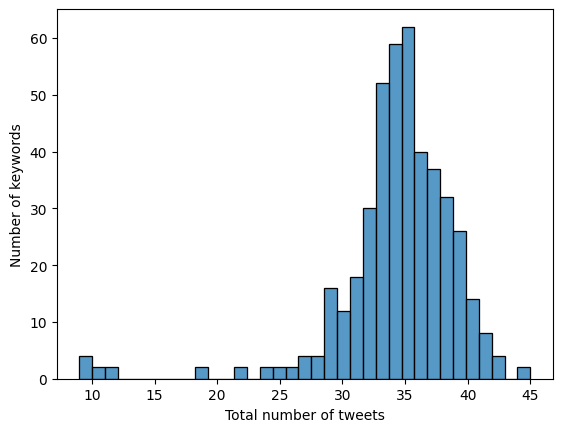

In [13]:
sns.histplot(data = n_tweets_keyword.to_pandas(),x = 'Total number of tweets').set(ylabel = 'Number of keywords')

The plot shows top 20 keywords on the target variable. It is not a supprise that the target variable have differences in keyword. Later we will check if keyword can lead to a better ML model.

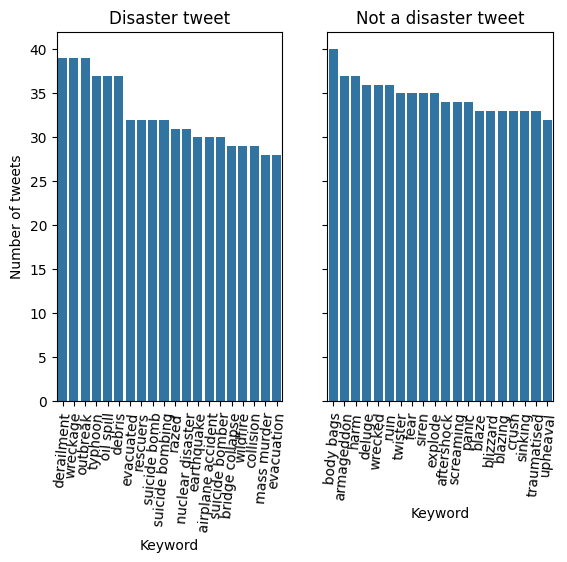

In [14]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,sharey=True)


sns.barplot(data = n_tweets_keyword
                    .filter(pl.col('Target')=='Disaster tweet',
                            pl.col('rank')<=20)
                    .to_pandas(),
                    x = 'Keyword',
                    y = 'Number of tweets',
                    ax = ax[0]).set(title = 'Disaster tweet')

sns.barplot(data = n_tweets_keyword
                    .filter(pl.col('Target')!='Disaster tweet',
                            pl.col('rank')<=20)
                    .to_pandas(),
                    x = 'Keyword',
                    y = 'Number of tweets',
                    ax=ax[1]).set(title = 'Not a disaster tweet')
ax[0].tick_params(axis='x', labelrotation=85)
ax[1].tick_params(axis='x', labelrotation=85)
plt.subplots_adjust(hspace = 10)

fig.show()

In [15]:
data = data.rename({'target':'target_variable'})

## Fit model

Define preprocessor classes

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

# Custom transformer for sklearn pipeline
class polars_onehot_encoding(BaseEstimator, TransformerMixin):
    
    def __init__(self,column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        # To dummies
        X_dummies = X.to_dummies(columns = self.column)
        
        # The new column
        dummies_columns = list(set(X_dummies.columns) - set(X.columns))
        
        # Cast the dummies to int64
        X_dummies = X_dummies.with_columns(*[pl.col(c).cast(pl.Int64) for c in dummies_columns])

        return X_dummies


# tfidf
class polars_tf_idf(BaseEstimator, TransformerMixin):
    def __init__(self,column):
        self.column = column 
    
    def fit(self,X,y = None):
        
                
        self.tfidf_vectorizer = TfidfVectorizer()
        self.tfidf_vectorizer.fit(X[self.column].to_list())
         
        return self 
    
    def transform(self,X):
    # Transform the text data to tf-idf vectors
     tfidf_vector = self.tfidf_vectorizer.transform(X[self.column].to_list())
     
     # Convert to polars DataFrame
     tf_idf_df = pl.DataFrame(tfidf_vector.toarray(), schema=list(self.tfidf_vectorizer.get_feature_names_out()))
     
     # Rename the tf_idf columns
     tf_idf_df = tf_idf_df.rename({col: "tf_idf_" + col for col in tf_idf_df.columns})
     
     return tf_idf_df


Define training and test

In [24]:
X = data.select(pl.all().exclude('target_variable'))
y = data.select('target_variable')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Define pipeline

In [25]:
# Define preprocessor
preprocessor = ColumnTransformer(transformers=[('one_hot_encoding_pl',polars_onehot_encoding(column='cleaned_keyword'),['cleaned_keyword']),
                                               ('tf_idf_pl',polars_tf_idf(column='cleaned_text'),['cleaned_text'])])

# Into pipeline
pipeline = Pipeline([('preprocessor',preprocessor),
                     ('xgb_classifier',XGBClassifier(random_state = 42))
                      ])



In [26]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot_encoding_pl',
                                                  polars_onehot_encoding(column='cleaned_keyword'),
                                                  ['cleaned_keyword']),
                                                 ('tf_idf_pl',
                                                  polars_tf_idf(column='cleaned_text'),
                                                  ['cleaned_text'])])),
                ('xgb_classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [62]:
y_pred = pipeline.predict(X_test)
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL: 0.7721602101116218


# Analyze the results

Creating confusion matrix

<Axes: >

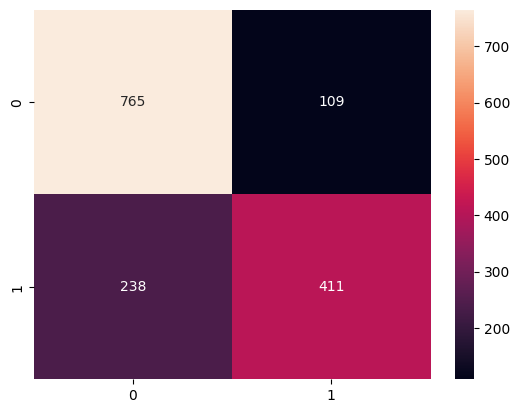

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import seaborn as sns
import matplotlib.pyplot as plt    
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  

F1 and precision

In [74]:
f'F1-score: {f1_score(y_test, y_pred, average="macro")}, Precision: {precision_score(y_test, y_pred, average="micro")}'

'F1-score: 0.7591478129060396, Precision: 0.7721602101116218'